In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency, ks_2samp

In [2]:
# Defina o caminho para o arquivo train.csv
file_path = r'C:\Users\Kkk\3D Objects\HCT\df_imputed.csv'

# Leia o arquivo CSV
df = pd.read_csv(file_path)
df2 = df.copy()
# Exiba as primeiras linhas do dataframe
#df.head()


In [3]:
# Definir os estratos
estratos = ['age_at_hct', 'ethnicity', 'race_group', 'sex_match', 'graft_type']

# Criar a amostra estratificada
df_sample = df.groupby(estratos, group_keys=False).apply(lambda x: x.sample(frac=1.0, random_state=1))

# Se a amostra for maior que 10.000 linhas, amostrar novamente para reduzir para 10.000 linhas
if len(df_sample) > 10000:
    df_sample = df_sample.sample(n=10000, random_state=1)
else:
    # Se a amostra for menor que 10.000 linhas, complementar com amostras aleatórias do DataFrame original
    df_sample = pd.concat([df_sample, df.drop(df_sample.index).sample(n=10000 - len(df_sample), random_state=1)])

# Verificar o tamanho da amostra final
print(f"Tamanho da amostra final: {len(df_sample)}")

# Salvar a amostra final em um arquivo CSV
df_sample.to_csv('amostra_estratificada_final.csv', index=False)
print("Amostra salva em 'amostra_estratificada_final.csv'")


Tamanho da amostra final: 10000
Amostra salva em 'amostra_estratificada_final.csv'


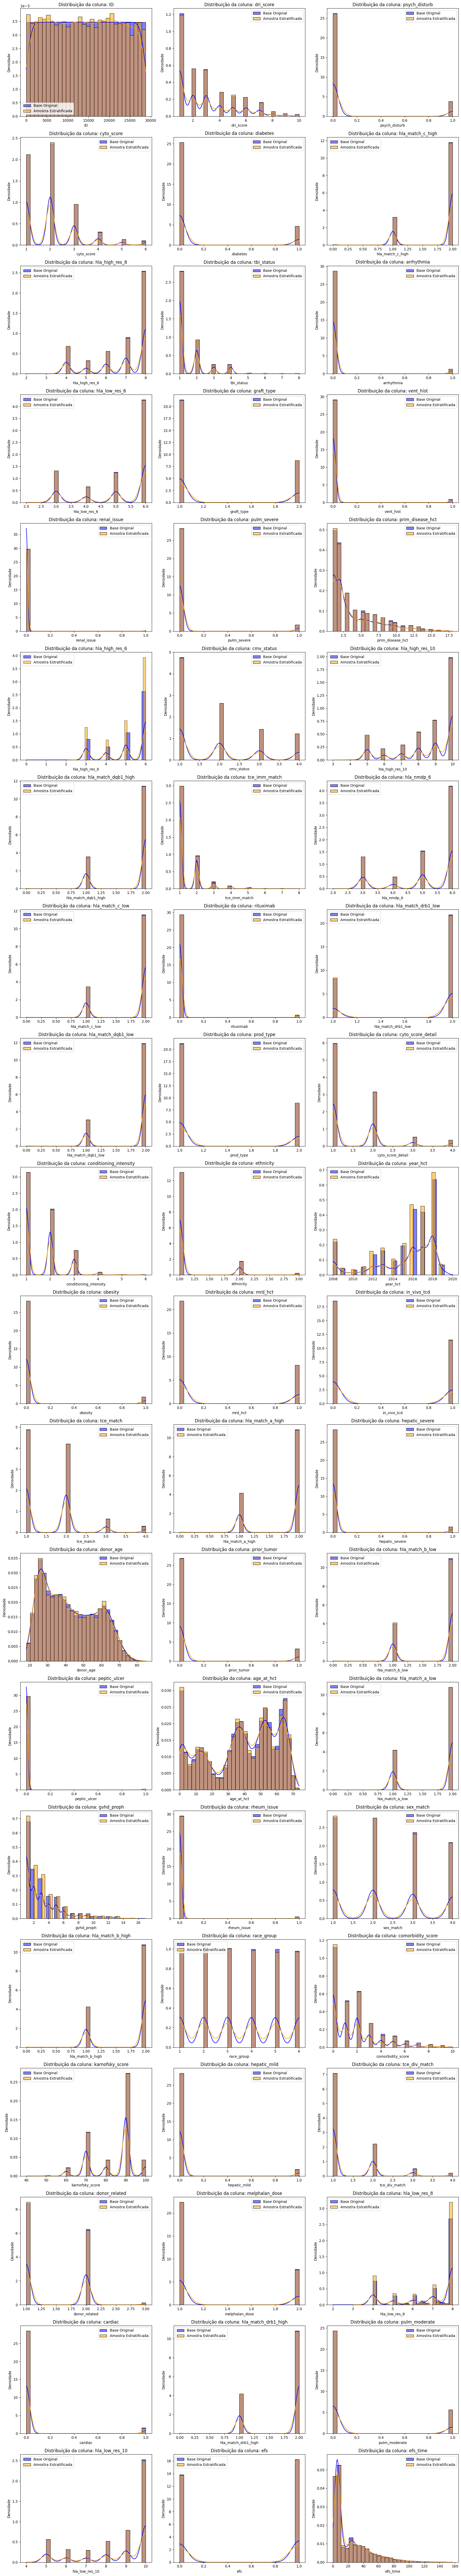

Coluna: ID, Valor p: 0.5287227243979125
Coluna: dri_score, Valor p: 0.8725775593633485
Coluna: psych_disturb, Valor p: 1.0
Coluna: cyto_score, Valor p: 0.9968733696091916
Coluna: diabetes, Valor p: 1.0
Coluna: hla_match_c_high, Valor p: 0.9965728953075945
Coluna: hla_high_res_8, Valor p: 0.8539927484523017
Coluna: tbi_status, Valor p: 0.9999753941303682
Coluna: arrhythmia, Valor p: 1.0
Coluna: hla_low_res_6, Valor p: 0.955893348271043
Coluna: graft_type, Valor p: 0.9358772208513803
Coluna: vent_hist, Valor p: 1.0
Coluna: renal_issue, Valor p: 1.0
Coluna: pulm_severe, Valor p: 1.0
Coluna: prim_disease_hct, Valor p: 0.9739358186515831
Coluna: hla_high_res_6, Valor p: 0.5266054335187884
Coluna: cmv_status, Valor p: 0.9999368831963136
Coluna: hla_high_res_10, Valor p: 0.929299708113225
Coluna: hla_match_dqb1_high, Valor p: 0.999994420420719
Coluna: tce_imm_match, Valor p: 0.9997952114461355
Coluna: hla_nmdp_6, Valor p: 0.9321308624780261
Coluna: hla_match_c_low, Valor p: 0.9645094796575742

In [4]:
# Função para verificar distribuições visuais
def plot_distribuicoes(base_original, amostra_estratificada, colunas_verificacao):
    num_cols = 3  # Número de colunas na grade
    num_rows = (len(colunas_verificacao) + num_cols - 1) // num_cols  # Calcula o número de linhas
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, num_rows * 5))
    fig.subplots_adjust(hspace=0.5, wspace=0.4)

    for i, coluna in enumerate(colunas_verificacao):
        row = i // num_cols  # Determina a linha da grade
        col_position = i % num_cols  # Determina a posição da coluna

        sns.histplot(base_original[coluna], color='blue', label='Base Original', kde=True, stat="density", bins=30, ax=axes[row, col_position])
        sns.histplot(amostra_estratificada[coluna], color='orange', label='Amostra Estratificada', kde=True, stat="density", bins=30, ax=axes[row, col_position])

        axes[row, col_position].legend()
        axes[row, col_position].set_title(f'Distribuição da coluna: {coluna}')
        axes[row, col_position].set_xlabel(coluna)
        axes[row, col_position].set_ylabel('Densidade')

    # Remove qualquer eixo que não esteja sendo usado
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

# Função para Teste de Chi-Quadrado
def chi2_test(base_original, amostra_estratificada, colunas_categoricas):
    resultados = {}
    for coluna in colunas_categoricas:
        contingencia = pd.crosstab(base_original[coluna], amostra_estratificada[coluna])
        chi2, p, _, _ = chi2_contingency(contingencia)
        resultados[coluna] = p
    return resultados

# Função para Teste de Kolmogorov-Smirnov
def ks_test(base_original, amostra_estratificada, colunas_continuas):
    resultados = {}
    for coluna in colunas_continuas:
        ks_stat, p = ks_2samp(base_original[coluna].dropna(), amostra_estratificada[coluna].dropna())
        resultados[coluna] = p
    return resultados

# Função para avaliar eficácia
def avaliar_eficacia(base_original, amostra_estratificada):
    colunas_categoricas = base_original.select_dtypes(include=['object']).columns.tolist()
    colunas_continuas = base_original.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Teste de Chi-Quadrado para colunas categóricas
    chi2_resultados = chi2_test(base_original, amostra_estratificada, colunas_categoricas)

    # Teste de Kolmogorov-Smirnov para colunas contínuas
    ks_resultados = ks_test(base_original, amostra_estratificada, colunas_continuas)

    # Combinar resultados
    resultados = {**chi2_resultados, **ks_resultados}

    return resultados

# Separação da amostra estratificada
estratos = ['age_at_hct', 'ethnicity', 'race_group', 'sex_match', 'graft_type']
df_sample = df.groupby(estratos, group_keys=False).apply(lambda x: x.sample(frac=1.0, random_state=1))

if len(df_sample) > 10000:
    df_sample = df_sample.sample(n=10000, random_state=1)
else:
    df_sample = pd.concat([df_sample, df.drop(df_sample.index).sample(n=10000 - len(df_sample), random_state=1)])

# Gerar visualizações para verificar a distribuição das colunas
plot_distribuicoes(df, df_sample, df.columns.tolist())

# Avaliar a eficácia da amostra
resultados_eficacia = avaliar_eficacia(df, df_sample)
for coluna, p_value in resultados_eficacia.items():
    print(f"Coluna: {coluna}, Valor p: {p_value}")